Trey Tuscai and Gordon Doore

Spring 2025

CS 444: Deep Learning

#### Project 4: Transformers

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

![Some fun](images/transformer2.png)

## Task 5: Create GPT networks

With the Transformer Block and other network components implemented, let's build an actual transformer! We are implementing a transformer that follows the design of OpenAI's GPT line of neural networks. Therefore, the network class is called `GPT` (still inherits from `DeepNetwork` like usual). Specific GPT networks that you will construct will be child classes of `GPT` (much like `ResNet8` and `ResNet18` were child classes of `ResNet`).

### 5a. Building `GPTPico1`

Let's build a minimal GPT that consists of only one Transformer Block. This network, `GPTPico1`, has the following architecture:
1. Embedding layer
2. Positional encoding block.
3. Transformer block (1x)
4. Dense output layer

Implement and test the following required methods:
- `GPT`: constructor.
- `GPT`: `__call__` method. Forward pass through the transformer.
- `GPTPico1`: constructor. Assemble the net (*see above*).

In [2]:
from gpts import GPT, GPTPico1

#### Test: `loss` (temporal cross-entropy)

In [27]:
mygpt = GPT(seq_len=4, padding_char_enc=10)
mygpt.loss_name = 'temporal_cross_entropy'

tf.random.set_seed(1)
y_pred = tf.random.uniform(shape=(5, 4, 12), maxval=1, dtype=tf.float32)
y_true = tf.random.uniform(shape=(5, 4), maxval=11, dtype=tf.int32)

# Test 1: no masking the padding char
loss = mygpt.loss(y_pred, y_true, mask_padding_preds=False)
print(f'When not masking out the padding char, your loss is {loss.numpy():.4f} and it should be 0.9513.')
# Test 2: masking the padding char
loss = mygpt.loss(y_pred, y_true)
print(f'When masking out the padding char, your loss is {loss.numpy():.4f} and it should be 0.9442.')

When not masking out the padding char, your loss is 0.9513 and it should be 0.9513.
When masking out the padding char, your loss is 0.9442 and it should be 0.9442.


#### Test: `GPTPico1` architecture

In [44]:
mypicogpt = GPTPico1(vocab_sz=9, seq_len=15, padding_char_enc=5)
mypicogpt.compile(loss='temporal_cross_entropy')

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 15, 9]
TransformerBlock_0:
	TransformerBlock_0/MLP:
	Dropout layer output(TransformerBlock_0/MLP/dropout) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_1) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_0) shape: [1, 15, 96]
	TransformerBlock_0/multihead_attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/dropout) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/dense_1) shape: [1, 15, 24]
	TransformerBlock_0/multihead_attention/attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/attention/dropout) shape: [1, 4, 15, 15]
	TransformerBlock_0/multihead_attention/qkv_block:
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_v) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_k) shape: [1, 15, 24]
	Den

The above cell should print out:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 15, 9]
TransformerBlock_0:
	TransformerBlock_0/MLP:
	Dropout layer output(TransformerBlock_0/MLP/dropout) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_1) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_0) shape: [1, 15, 96]
	TransformerBlock_0/multihead_attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/dropout) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/dense_1) shape: [1, 15, 24]
	TransformerBlock_0/multihead_attention/attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/attention/dropout) shape: [1, 4, 15, 15]
	TransformerBlock_0/multihead_attention/qkv_block:
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_v) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_k) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_q) shape: [1, 15, 24]
PositionalEncodingBlock:
	Dropout layer output(PositionalEncodingBlock/dropout) shape: [1, 15, 24]
	Positional encoding layer output(PositionalEncodingBlock/positional_enc_layer) shape: [1, 15, 24]
Embedding layer output(EmbeddingLayer) shape: [1, 15, 24]
---------------------------------------------------------------------------
```

### 5b. `GPTPico1` overfit test

Let's verify that your `GPTPico1` works by overfitting a small amount of fake data.

Running the following cell should result in a training loss of ~`0.03` by 500 training epochs. The training loss after 1 epoch should be ~`5.0`.

In [46]:
tf.random.set_seed(0)
mypicogpt = GPTPico1(vocab_sz=100, seq_len=5, padding_char_enc=99)
mypicogpt.compile(loss='temporal_cross_entropy')

tf.random.set_seed(1)
x_dev_test = tf.random.uniform(shape=(10, 5), maxval=100, dtype=tf.int32)
y_dev_test = tf.random.uniform(shape=(10, 5), maxval=100, dtype=tf.int32)
train_loss_hist, _, _, _ = mypicogpt.fit(x_dev_test, y_dev_test, x_dev_test, y_dev_test, batch_size=10, max_epochs=500)

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 5, 100]
TransformerBlock_0:
	TransformerBlock_0/MLP:
	Dropout layer output(TransformerBlock_0/MLP/dropout) shape: [1, 5, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_1) shape: [1, 5, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_0) shape: [1, 5, 96]
	TransformerBlock_0/multihead_attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/dropout) shape: [1, 5, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/dense_1) shape: [1, 5, 24]
	TransformerBlock_0/multihead_attention/attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/attention/dropout) shape: [1, 4, 5, 5]
	TransformerBlock_0/multihead_attention/qkv_block:
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_v) shape: [1, 5, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_k) shape: [1, 5, 24]
	Dense layer

## Task 6: Train GPTs on the Addition Dataset

In task, you will train small transformers on the Addition dataset, have the transformers generate the answers to addition problems, and analyze the properties of the trained transformers.

### 6a. Train `GPTPico1` on a small amount of Addition Dataset expressions

In the cell below, train `GPTPico1` on the first 25 samples from the Addition dataset. Use:
- the training set as the validation set
- the default random seed.
- a patience of `15` (no learning rate decay).
- a batch size of `25` (*batch gradient descent*).

You should get a final training loss of less than `0.20`.

Make a well-labeled plot showing the training loss over the course of training.

In [47]:
from addition_dataset import *

In [105]:
x_train, y_train, _, _, char2ind_map = get_addition_dataset(N=25, val_prop=0.)
vocab_sz = len(char2ind_map)
seq_len = x_train.shape[1]

print('First 5 expressions (encoded)')
print(x_train[:5].numpy())
print('First 5 target labels (encoded)')
print(y_train[:5].numpy())

First 5/25 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']
First 5 expressions (encoded)
[[ 4  7 10  5  1 11  9  8 12]
 [ 7  5 10  9  5 11  1  7  0]
 [ 3 10  1  4 11  1  7 12 13]
 [ 8  2 10  9  4 11  1  7  6]
 [ 2  4 10  3  1 11  5  5 12]]
First 5 target labels (encoded)
[[ 7 10  5  1 11  9  8 12 13]
 [ 5 10  9  5 11  1  7  0 12]
 [10  1  4 11  1  7 12 13 13]
 [ 2 10  9  4 11  1  7  6 12]
 [ 4 10  3  1 11  5  5 12 13]]


In [111]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

gpt_add = GPTPico1(vocab_sz=vocab_sz, seq_len=seq_len, padding_char_enc=char2ind_map['#'])
gpt_add.compile(loss='temporal_cross_entropy')
train_loss_hist, _, _, _ = gpt_add.fit(x_train, y_train, x_train, y_train, batch_size=25, patience = 15, max_epochs=500)

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 9, 14]
TransformerBlock_0:
	TransformerBlock_0/MLP:
	Dropout layer output(TransformerBlock_0/MLP/dropout) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_1) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_0) shape: [1, 9, 96]
	TransformerBlock_0/multihead_attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/dropout) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/dense_1) shape: [1, 9, 24]
	TransformerBlock_0/multihead_attention/attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/attention/dropout) shape: [1, 4, 9, 9]
	TransformerBlock_0/multihead_attention/qkv_block:
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_v) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_k) shape: [1, 9, 24]
	Dense layer 

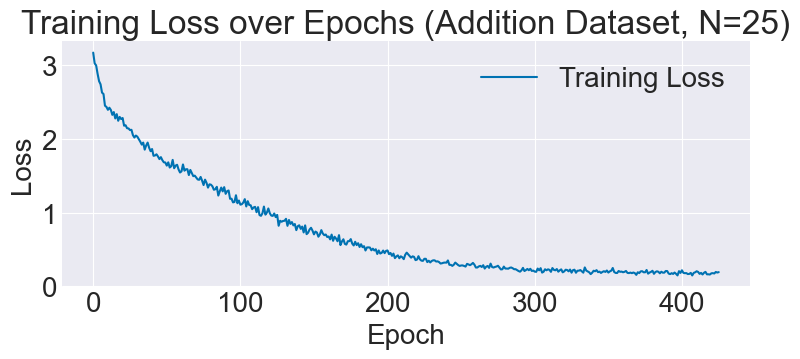

In [112]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss_hist, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs (Addition Dataset, N=25)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 6b. Test `generate_sequence`

This is the method that allows you to prompt your transformer and have it generate text that follows your prompt.

Test it out in the cell below on your GPTPico1 network **trained** on the first 25 addition expressions (*the one that yielded a final training loss of less than `0.20` above*) by prompting it with the left-hand side of a single one of the 25  training samples.

For example, if you prompt `'47+51='` (the 1st sample) it should output `98.` (or `'47+51=98.'` if you have chatbot-style character-by-character live printing turned on as it generates).

Another example prompt is `'75+95='` (2nd sample), which should output `170.` (or `'75+95=170.'` if live printing is on).

**Note:** The end character is set to `'.'`.

In [113]:
ind2char_map = make_ind2char_mapping(char2ind_map)

prompt = '75+95='

answer = gpt_add.generate_sequence(prompt=prompt,
                                   length=seq_len,
                                   char2ind_map=char2ind_map,
                                   ind2char_map=ind2char_map,
                                   end_char='.')

75+95=170.


### 6c. Verify transformer overfits all 25 addition expressions

Once you have the above `generate_sequence` test working, "script" your GPT to generate the answers to all 25 addition expressions in the current subset of the addition dataset. When you print out the generated answers, also print out the true answer so that you can visually scan the correctness of the outputs. Your `GPTPico1` should get all or the vast majority of additions correct.

**Reminders:**
- Make sure you set the end character to the appropriate char.
- Use the `convert_int2str` and `split_sum_and_answer` methods that you wrote to prepare the prompts and expected answers for each sample.

In [109]:
from addition_dataset import convert_int2str, split_sum_and_answer

In [114]:

input_str = convert_int2str(x_train.numpy(), ind2char_map)
output_str = convert_int2str(y_train.numpy(), ind2char_map)

for i in range(len(input_str)):
    expression = ''.join(input_str[i])
    sum, ans = split_sum_and_answer([expression])
    print(f"Prompt: {sum}")
    
    generated_answer = gpt_add.generate_sequence(prompt=sum[0],
                                                 length=seq_len,
                                                 char2ind_map=char2ind_map,
                                                 ind2char_map=ind2char_map,
                                                 end_char='.')
    print(f"True Answer: {ans}\n")


Prompt: ['47+51=']
47+51=98.
True Answer: ['98.']

Prompt: ['75+95=']
75+95=170.
True Answer: ['170']

Prompt: ['3+14=']
3+14=17.
True Answer: ['17.#']

Prompt: ['82+94=']
82+94=176.
True Answer: ['176']

Prompt: ['24+31=']
24+31=55.
True Answer: ['55.']

Prompt: ['86+42=']
86+42=128.
True Answer: ['128']

Prompt: ['27+82=']
27+82=109.
True Answer: ['109']

Prompt: ['25+40=']
25+40=65.
True Answer: ['65.']

Prompt: ['64+54=']
64+54=118.
True Answer: ['118']

Prompt: ['8+2=']
8+2=10.
True Answer: ['10.##']

Prompt: ['86+75=']
86+75=161.
True Answer: ['161']

Prompt: ['83+53=']
83+53=136.
True Answer: ['136']

Prompt: ['81+32=']
81+32=113.
True Answer: ['113']

Prompt: ['45+78=']
45+78=123.
True Answer: ['123']

Prompt: ['12+30=']
12+30=42.
True Answer: ['42.']

Prompt: ['12+45=']
12+45=57.
True Answer: ['57.']

Prompt: ['97+13=']
97+13=110.
True Answer: ['110']

Prompt: ['38+40=']
38+40=78.
True Answer: ['78.']

Prompt: ['90+20=']
90+20=110.
True Answer: ['110']

Prompt: ['50+26=']
50+2

### 6d. Transformer learns to add

In the cell below, train `GPTPico1` on an addition dataset with `25000` expressions the default configuration (e.g. 90/10 train/val split). Use default network and training hyperparameters except for:
- batch size of `1024`.
- patience of `15`.
- learning rate patience of `5`.
- at most `4` learning rate decays.
- at most `1200` training epochs.

Do the following after training your net:
1. Create a well-labeled plot showing the training and validation loss over epochs.
2. Print out of the generated answers for the 1st 50 **training AND validation set** samples separately. Each print out should show the prompt (left-hand side of `=`, including the `=`), the answer generated by the transformer, and the correct answer — all in a neat, easy to read format.

*If everything is working as expected, you should be able to achieve a validation loss in the 0.9s*

In [101]:
from addition_dataset import *

In [117]:
x_train, y_train, x_val, y_val, char2ind_map = get_addition_dataset(N=25000, val_prop=0.1)
vocab_sz = len(char2ind_map)
seq_len = x_train.shape[1]

First 5/25000 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# Your code here
gpt_add1 = GPTPico1(vocab_sz=vocab_sz, seq_len=seq_len, padding_char_enc=char2ind_map['#'])
gpt_add1.compile(loss='temporal_cross_entropy')
train_loss_hist, val_loss_hist, _, _ = gpt_add.fit(x_train, y_train, x_val, y_val, batch_size=1024, patience=15, max_epochs=1200, lr_max_decays=4, lr_patience=5)

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 9, 14]
TransformerBlock_0:
	TransformerBlock_0/MLP:
	Dropout layer output(TransformerBlock_0/MLP/dropout) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_1) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_0) shape: [1, 9, 96]
	TransformerBlock_0/multihead_attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/dropout) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/dense_1) shape: [1, 9, 24]
	TransformerBlock_0/multihead_attention/attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/attention/dropout) shape: [1, 4, 9, 9]
	TransformerBlock_0/multihead_attention/qkv_block:
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_v) shape: [1, 9, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_k) shape: [1, 9, 24]
	Dense layer 

In [ ]:
N_show = 50
x_splits = [x_train, x_val]
split_labels = ['train', 'val']

for i in range(2):
    x = x_splits[i]
    split = split_labels[i]

    print(50*'=')
    print(split)
    print(50*'=')
    N = len(x)

    ind2char_map = make_ind2char_mapping(char2ind_map)
    x_str = convert_int2str(x_int=x.numpy(), ind2char_map=ind2char_map)
    prompts, correct_answers = split_sum_and_answer(x_str)


    for i in range(N_show):
        curr_prompt = prompts[i]
        curr_ans = correct_answers[i]
        answer = gpt_add1.generate_sequence(prompt=curr_prompt,
                                            length=seq_len,
                                            char2ind_map=char2ind_map,
                                            ind2char_map=ind2char_map,
                                            end_char='.')
        print('Correct answer is:', curr_ans)
        print('---------------------')

### 6e. Questions

**Question 4:** Look over the addition prompts and generated answers for mistakes.

a. What types of mistakes do you spot?

b. How close are the mistakes to the true answers?

c. Why do you think the transformer is making the mistakes it makes?

*If your transformer is not making mistakes, print out more prompts/answers or cut the training off a little earlier so the final validation loss is higher.*

<br/><br/>

**Question 5:** Have some fun and prompt your trained transformer with hand crafted addition prompt strings. Try to "trick" your transformer:

a. using valid prompts (i.e. up to 2 digits per operand). 

b. using invalid prompts. 

In both cases document where it does well and where it does not with specific examples.

<br/><br/>

**Question 6:** Add the following code to your GPT's temporal cross entropy loss code: `print(tf.reshape(act_at_correct, (N, T)))` The line of code prints the softmax netAct values produced by the net's output layer from the neuron coding the correct next token. Adapt as necessary to make it print these expected values. Run the code provided below. In some detail, interpret why the netActs are high or low in each case and why that makes sense.

<br/><br/>

**Question 7:** Following up from the previous question, notice how the netActs for the 1st char are small yet nonzero in all cases. Why does this happen and explain why the loss cannot get to exactly 0. 

**When you are done running Q6 and Q7, comment out the print out in the `loss` method.**

<br/><br/>

**Question 8:** In the cell below, call `generate_sequence` on one of the transformers and plug in a single prompt that yields an incorrect answer based on the above validation set print outs. In your call to `generate_sequence`, set the keyword argument `plot_probs` to `True`. Use the plots of the output layer netActs to explain what is going on when the network predicts the incorrect answer.

**Answer 4:**

**Answer 5:**

**Answer 6:**

**Answer 7:**

**Answer 8:**

In [ ]:
# Question 6 TODO: Replace in the code below:
# char2ind_map: with your char-to-int dictionary
# gpt_add1: with your trained net

prompts = [list('33+1=34.##'), list('33+10=43.#'), list('33+33=66.#')]
prompts_int_x, prompts_int_y = make_addition_samples_and_labels(prompts, char2ind_map)
prompts_int_x = tf.cast(prompts_int_x, tf.int32)
prompts_int_y = tf.cast(prompts_int_y, tf.int32)
net_acts = gpt_add1(prompts_int_x)
gpt_add1.loss(net_acts, prompts_int_y)


In [ ]:
# Question 8.
# TODO: modify prompt to one that produces an incorrect output. Change any other variables to suit your conventions
prompt = '2+87='
answer = gpt_add1.generate_sequence(prompt=prompt,
                                length=seq_len,
                                char2ind_map=char2ind_map,
                                ind2char_map=ind2char_map,
                                end_char='.',
                                plot_probs=True)